In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a83005cfdbed5903d8ba239e8cf1b4c2239d95697e67c7ac971f1962a443f62b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.4 MB/s eta 0:00:00


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from lime import lime_image
from skimage.segmentation import slic
import shap
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [4]:
# Define the CNN model with attention
def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    attention = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Create and train the model
model = create_model(input_shape=(32, 32, 3), num_classes=10)
model.summary()
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 1)        │            129 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 4, 4, 128)      │              0 │ max_pooling2d_2[0][0], │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 128)            │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10)             │          1,290 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 111,179 (434.29 KB)

 Trainable params: 111,179 (434.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 163ms/step - accuracy: 0.2543 - loss: 1.9853 - val_accuracy: 0.4110 - val_loss: 1.5926
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 160ms/step - accuracy: 0.4322 - loss: 1.5384 - val_accuracy: 0.4551 - val_loss: 1.4574
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.4934 - loss: 1.3867 - val_accuracy: 0.5311 - val_loss: 1.2839
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 165ms/step - accuracy: 0.5404 - loss: 1.2679 - val_accuracy: 0.5516 - val_loss: 1.2218
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.5725 - loss: 1.1841 - val_accuracy: 0.5930 - val_loss: 1.1469
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 160ms/step - accuracy: 0.6052 - loss: 1.1101 - val_accuracy: 0.6019 - val_loss: 1.1183
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 159ms/step - accuracy: 0.6179 - loss: 1.0689 - val_accuracy: 0.6289 - val_loss: 1.0501
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 156ms/step - accuracy: 0.6387 -

In [7]:
def preprocess_image(image_path, target_size):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return img_array

In [8]:
def grad_cam(model, img, class_idx):
    last_conv_layer = model.get_layer('conv2d_2')
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.expand_dims(img, axis=0))
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

In [9]:
def display_grad_cam(img, heatmap, class_idx, class_names):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + img
    plt.imshow(superimposed_img / 255.0)
    plt.title(f"Class: {class_names[class_idx]}")
    plt.axis('off')
    plt.show()

In [10]:
# Rule-based explanation function
def generate_explanation(predicted_class):
    explanations = {
        0: "This image is classified as 'airplane' because of its shape and wings.",
        1: "This image is classified as 'automobile' due to its wheels and body shape.",
        2: "This image is classified as 'bird' due to its beak and feather patterns.",
        3: "This image is classified as 'cat' due to its fur pattern and whiskers.",
        4: "This image is classified as 'deer' because of its antlers and body shape.",
        5: "This image is classified as 'dog' due to its snout, fur, and tail.",
        6: "This image is classified as 'frog' due to its shape and color.",
        7: "This image is classified as 'horse' because of its mane and body structure.",
        8: "This image is classified as 'ship' due to its hull and sails.",
        9: "This image is classified as 'truck' because of its large wheels and body shape."
    }
    return explanations.get(predicted_class, "No explanation available")

In [11]:
# Local explanation with LIME
def explain_with_lime(model, img):
    explainer = lime_image.LimeImageExplainer()
    def predict_fn(images):
        return model.predict(images)
    explanation = explainer.explain_instance(img, predict_fn, segmentation_fn=slic)
    return explanation

In [12]:
def visualize_lime_explanation(explanation, img):
    temp, mask = explanation.get_image_and_mask(
        label=class_idx,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("LIME Explanation")
    plt.imshow(temp, cmap='gray')
    plt.axis('off')
    plt.show()

In [13]:
# Local explanation with SHAP
def explain_with_shap(model, img, x_train):
    explainer = shap.KernelExplainer(lambda x: model.predict(x), x_train[:100])
    shap_values = explainer.shap_values(img[np.newaxis, ...])
    return shap_values

In [14]:
def visualize_shap_explanation(shap_values, img):
    shap.image_plot(shap_values, [img])

In [15]:
def extract_color_features(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [39]:
def advanced_rule_based_integration(features, prediction):
    if features[0] > 0.1:
        prediction = 1
    return prediction

In [40]:
# Example usage with picture.jpg
image_path = 'picture.jpg'
img = preprocess_image(image_path, target_size=(32, 32))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [42]:
def grad_cam(model, img, class_idx):
    last_conv_layer = model.get_layer('conv2d_7')
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.expand_dims(img, axis=0))

In [43]:
def display_grad_cam(img, heatmap, class_idx, class_names):
    if heatmap is None:
        print("Error: Heatmap is None. Check the grad_cam function.")
        return

    print("Image shape:", img.shape)
    print("Heatmap shape:", heatmap.shape)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

In [44]:
def grad_cam(model, img, class_idx):
    #Find the actual name of the last convolutional layer
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer

    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.expand_dims(img, axis=0))

In [45]:
class_idx = np.argmax(model.predict(np.expand_dims(img, axis=0)))
heatmap = grad_cam(model, img, class_idx)
display_grad_cam(img, heatmap, class_idx, class_names)
print(generate_explanation(class_idx))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Error: Heatmap is None. Check the grad_cam function.
This image is classified as 'airplane' because of its shape and wings.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

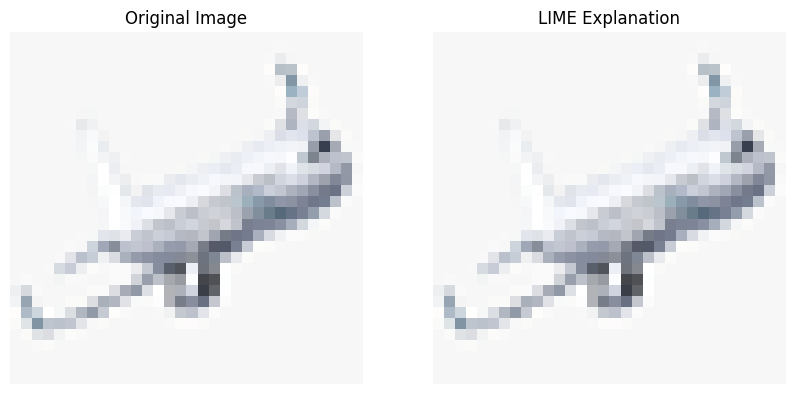

In [46]:
lime_explanation = explain_with_lime(model, img)
visualize_lime_explanation(lime_explanation, img)

In [47]:
def explain_with_shap(model, img, x_train):
    explainer = shap.DeepExplainer(model, x_train[:100])
    shap_values = explainer.shap_values(np.expand_dims(img, axis=0))
    return shap_values

def visualize_shap_explanation(shap_values, img):
    shap.image_plot(shap_values, np.expand_dims(img, axis=0))

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


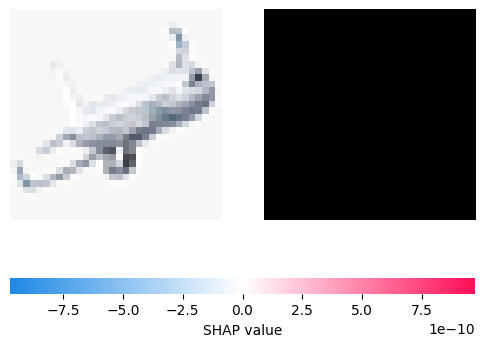

In [48]:
shap_values = explain_with_shap(model, img, x_train)
visualize_shap_explanation(shap_values, img)

In [49]:
def extract_color_features(img):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Calculate histogram for each color channel separately
    hist_b = cv2.calcHist([img], [0], None, [8], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [8], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [8], [0, 256])

    # Concatenate histograms and normalize
    hist = np.concatenate((hist_b, hist_g, hist_r)).flatten()
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [38]:
img_features = extract_color_features(img)
initial_prediction = np.argmax(model.predict(np.expand_dims(img, axis=0)))
final_prediction = advanced_rule_based_integration(img_features, initial_prediction)
print(f"Final Prediction with Advanced Rules: {class_names[final_prediction]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Final Prediction with Advanced Rules: airplane
